In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "knd"      # Used for tflite Filename
Training_Percentage = 0.2           
Epoch_Anz = 100
nb_classes = 10                     # move to 1. step
input_shape = (32, 20,3)

##########################################################################


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

def tmnist_percentals():
    x_train = np.empty((1,32,20,3))
    y_train = np.empty((1,1))
    for i in range(28):

        dataset_url = "datasets/TMNIST_PERCENTAL_"+str((i+1)*1000)+"_Data.csv"
        data = pd.read_csv(dataset_url, index_col=False)
        #print(data.head())
        y_tmnist = data[['labels']]
        X = data.drop({'labels','names'},axis=1)

        #print(data)
        X_images = X.values.reshape(-1,28,28,1)/255.
        x_tmnist = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_images))
        x_tmnist = tf.image.resize(x_tmnist, (32,20))

        x_train = np.concatenate((x_tmnist, x_train))
        y_train = np.concatenate((y_tmnist.values, y_train))
        #print(x_tmnist.shape, np.array(y_tmnist).shape)
    return x_train,  y_train


In [3]:
import matplotlib.pyplot as plt

def plot_dataset(images, labels, columns=12, rows=5):

    fig = plt.figure(figsize=(18, 10))
    columns = 12
    rows = 5

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title(labels[i])  # set title
        plt.imshow((images[i]))
    plt.show()

In [4]:
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Rescaling, LayerNormalization


def VGG_like(input_shape, nb_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(nb_classes, activation=None))
    return model

In [5]:
model = VGG_like(input_shape, nb_classes)

model.compile(loss=tf.keras.losses.mean_squared_error, 
              optimizer="adam", metrics = ["accuracy"])

2022-05-02 22:45:18.566051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-02 22:45:18.566167: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [6]:
x_train, y_train = tmnist_percentals()

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


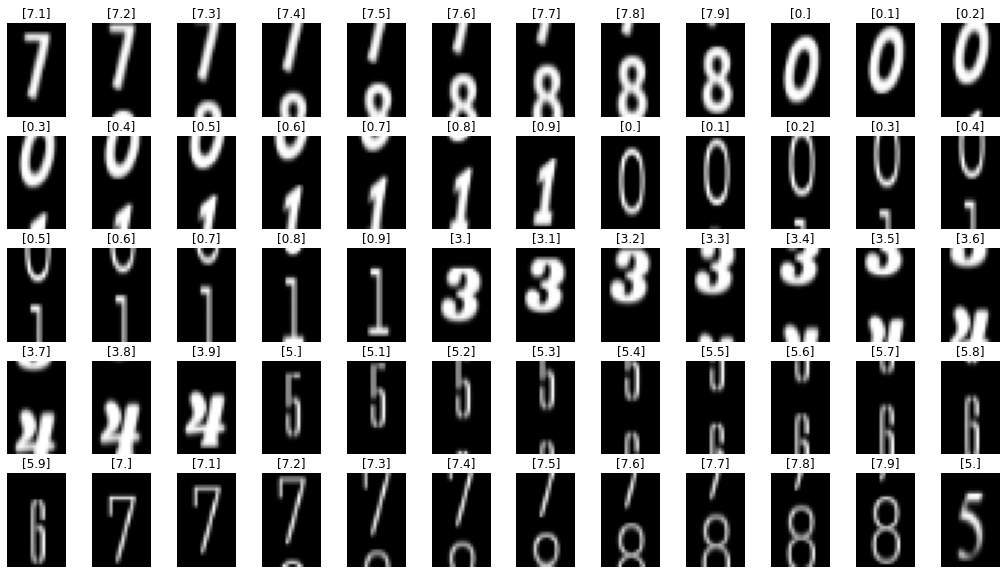

In [7]:
plot_dataset(x_train, y_train)

In [8]:
import tensorflow.keras as keras

def class_encoding(y_train, nb_classes):
    ret = np.zeros((len(y_train), nb_classes))
    print(ret.shape)
    for i, y in enumerate(y_train):
        ret[i, int(y)] = (1-(y-int(y)))
        ret[i, int((y+1)%10)] = y-int(y)
    return ret
    
y_train = class_encoding(y_train, nb_classes)


(280001, 10)


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 20, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 20, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 32, 20, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 10, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 10, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 10, 64)        1

In [10]:
model.fit(x_train, y_train, 
                validation_split = 0.2, 
                batch_size=32, 
                epochs = 30)

Epoch 1/30


2022-05-02 22:45:39.902375: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-02 22:45:40.302356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6998/7000 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.6920

2022-05-02 22:47:06.480077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7000/7000 [==============================] - 98s 14ms/step - loss: 0.0248 - accuracy: 0.6921 - val_loss: 0.0036 - val_accuracy: 0.9480
Epoch 2/30
7000/7000 [==============================] - 98s 14ms/step - loss: 0.0034 - accuracy: 0.9277 - val_loss: 0.0023 - val_accuracy: 0.9660
Epoch 3/30
7000/7000 [==============================] - 98s 14ms/step - loss: 0.0023 - accuracy: 0.9363 - val_loss: 0.0026 - val_accuracy: 0.9441
Epoch 4/30
7000/7000 [==============================] - 98s 14ms/step - loss: 0.0017 - accuracy: 0.9399 - val_loss: 0.0012 - val_accuracy: 0.9551
Epoch 5/30
5301/7000 [=====================>........] - ETA: 1:07 - loss: 0.0011 - accuracy: 0.9441

KeyboardInterrupt: 